# Heart Disease Analysis

Import the dataset and project dependencies

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
df = pd.read_csv("heart.csv")

In [22]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [23]:
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

## Data Visualization

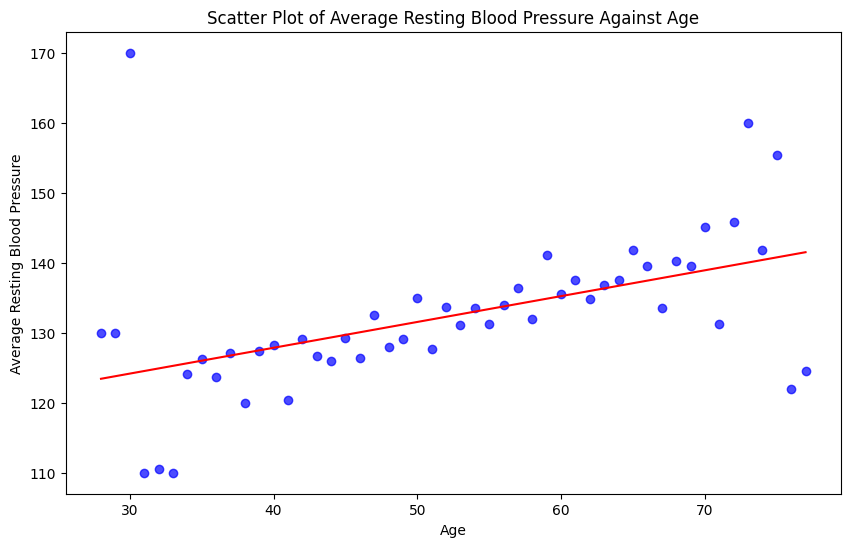

In [24]:
average_resting_bp = df.groupby('Age')['RestingBP'].mean().reset_index()

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(average_resting_bp['Age'], average_resting_bp['RestingBP'], color='blue', alpha=0.7)

# Add a line of best fit
coefficients = np.polyfit(average_resting_bp['Age'], average_resting_bp['RestingBP'], 1)
line = np.polyval(coefficients, average_resting_bp['Age'])
plt.plot(average_resting_bp['Age'], line, color='red', label='Line of Best Fit')

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Average Resting Blood Pressure')
plt.title('Scatter Plot of Average Resting Blood Pressure Against Age')

# Show the plot
plt.show()

As one gets older, their resting blood pressure tends to increase.

## Clean the data

There are concerning minimum values in cholesterol and resting blood pressure.

In [25]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


There are no null values.

In [26]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

There is a single row where an patient has a resting blood presssure of zero. We can remove this row.

In [27]:
df = df[df["RestingBP"] != 0]

There are a number of rows where the patient has a cholesterol of zero. We should replace those values with the average cholesterol since there are many of those rows.

In [28]:
# Replace zero Cholesterol with NaN
df['Cholesterol'] = df['Cholesterol'].replace(0, np.nan)

# Replace the NaN values with the mean Cholesterol.
df['Cholesterol'].fillna(df['Cholesterol'].mean(), inplace=True)

## Splitting the Data

In [29]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = \
# train_test_split(X, y, test_size=0.3, random_state=1)

## Classification Training

### Random Forest

#### Standardize the data

In [43]:
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    [
        ("one-hot-encoder", categorical_preprocessor, categorical_cols),
        ("standard_scaler", numerical_preprocessor, numerical_cols),
    ]
)

#### Create the model

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

model = make_pipeline(preprocessor, RandomForestClassifier(n_estimators=10, criterion="entropy", random_state=69))
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'FastingBS',
                                                   'MaxHR', 'Oldpeak'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', n_estimators=10,
                                        random_state=69))])

#### Split the data

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.3
)

#### Fit the model

In [46]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_pred = np.array(y_pred)
y_test = np.array(y_test)

# print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
# Calculate model accuracy
print("Accuracy:",accuracy_score(y_test, y_pred))
# Calculate model precision
print("Precision:",precision_score(y_test, y_pred))
# Calculate model recall
print("Recall:",recall_score(y_test, y_pred))
# Calculate model f1 score
print("F1-Score:",f1_score(y_test, y_pred))

[[ 95  12]
 [ 24 145]]
Accuracy: 0.8695652173913043
Precision: 0.9235668789808917
Recall: 0.8579881656804734
F1-Score: 0.8895705521472392


#### Hyperparameter Tuning

In [49]:
X1 = X
num_X1 = X1.select_dtypes(exclude=['object'])
X1[num_X1.columns] = numerical_preprocessor.fit_transform(num_X1)

X1 = pd.get_dummies(X1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X1, y, random_state=42, test_size=0.3
)

In [51]:
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.7s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.7s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.7s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   1.4s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   1.6s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   1.0s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800;

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [52]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 90,
 'bootstrap': True}

In [55]:
y_pred = rf_random.best_estimator_.predict(X_test)
y_pred = np.array(y_pred)
y_test = np.array(y_test)
accuracy_score(y_test, y_pred)


0.8876811594202898

In [53]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))



Model Performance
Average Error: 0.1739 degrees.
Accuracy = -inf%.
Model Performance
Average Error: 0.1123 degrees.
Accuracy = -inf%.
Improvement of nan%.


/tmp/ipykernel_26700/2078512554.py:18: RuntimeWarning: invalid value encountered in scalar subtract
  print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


### Decision Tree

#### Feature Scaling

In [34]:
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    [
        ("one-hot-encoder", categorical_preprocessor, categorical_cols),
        ("standard_scaler", numerical_preprocessor, numerical_cols),
    ]
)

#### Create the model

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

model = make_pipeline(preprocessor, DecisionTreeClassifier(criterion="entropy", random_state=69))
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'FastingBS',
                                                   'MaxHR', 'Oldpeak'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(criterion='entropy', random_state=69))])

#### Split the data

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.3
)

#### Fit the data

In [37]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_pred = np.array(y_pred)
y_test = np.array(y_test)

# print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
# Calculate model accuracy
print("Accuracy:",accuracy_score(y_test, y_pred))
# Calculate model precision
print("Precision:",precision_score(y_test, y_pred))
# Calculate model recall
print("Recall:",recall_score(y_test, y_pred))
# Calculate model f1 score
print("F1-Score:",f1_score(y_test, y_pred))

[[ 86  21]
 [ 31 138]]
Accuracy: 0.8115942028985508
Precision: 0.8679245283018868
Recall: 0.8165680473372781
F1-Score: 0.8414634146341463


### k-Neartest Neighbours

#### Feature Scaling

In [38]:
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    [
        ("one-hot-encoder", categorical_preprocessor, categorical_cols),
        ("standard_scaler", numerical_preprocessor, numerical_cols),
    ]
)

#### Create the model

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

model = make_pipeline(preprocessor, KNeighborsClassifier(n_neighbors=5))
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'FastingBS',
                                                   'MaxHR', 'Oldpeak'])])),
                ('kneighborsclassifier', KNeighborsClassifier())])

#### Split the data

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.3
)

#### Fit the data

In [42]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_pred = np.array(y_pred)
y_test = np.array(y_test)

# print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
# Calculate model accuracy
print("Accuracy:",accuracy_score(y_test, y_pred))
# Calculate model precision
print("Precision:",precision_score(y_test, y_pred))
# Calculate model recall
print("Recall:",recall_score(y_test, y_pred))
# Calculate model f1 score
print("F1-Score:",f1_score(y_test, y_pred))

[[ 88  19]
 [ 18 151]]
Accuracy: 0.8659420289855072
Precision: 0.888235294117647
Recall: 0.893491124260355
F1-Score: 0.8908554572271388
